In [14]:
import csv
import random
from faker import Faker
from datetime import datetime, timedelta

fake = Faker("en_PH")  # Use Filipino Names

with open('MO-IT148_Homework_IoT_Data_Simulation_A3101_Group_LMN.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Timestamp', 'Patient Name', 'Heart Rate (bpm)', 'SpO2 (%)', 'ECG (mV)', 'Body Temp (°C)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    base_time = datetime.now()

    for _ in range(500):  # generate N number of fake datasets
        writer.writerow({
            'Timestamp': (base_time + timedelta(seconds=_*30)).strftime("%Y-%m-%d %H:%M:%S"),
            'Patient Name': fake.name(),  # Now generates Filipino names
            'Heart Rate (bpm)': random.randint(60, 100),
            'SpO2 (%)': round(random.uniform(94, 100), 1),
            'ECG (mV)': round(random.uniform(0.8, 1.2), 2),
            'Body Temp (°C)': round(random.uniform(36.5, 38.5), 1)
        })

In [ ]:
from web3 import Web3

# Connect to Ganache
ganache_url = "http://127.0.0.1:7545"
web3 = Web3(Web3.HTTPProvider(ganache_url))

# Verify connection
if web3.is_connected():
    print("✅ Connected to Ganache successfully!")
else:
    print("❌ Connection failed. Ensure Ganache is running.")

# Contract address from Truffle
contract_address = "0xd90b97edd34833cCBeb8BD37E15eaeD2D9B96121"

# Paste ABI from build/contracts/IoTDataStorage.json
abi = [
    {
        "inputs": [],
        "stateMutability": "nonpayable",
        "type": "constructor"
    },
    {
        "inputs": [],
        "name": "MAX_ENTRIES",
        "outputs": [{"internalType": "uint256", "name": "", "type": "uint256"}],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "owner",
        "outputs": [{"internalType": "address", "name": "", "type": "address"}],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [{"internalType": "uint256", "name": "", "type": "uint256"}],
        "name": "records",
        "outputs": [
            {"internalType": "uint256", "name": "timestamp", "type": "uint256"},
            {"internalType": "string", "name": "patientId", "type": "string"},
            {"internalType": "string", "name": "deviceId", "type": "string"},
            {"internalType": "string", "name": "heartRate", "type": "string"},
            {"internalType": "string", "name": "spo2", "type": "string"},
            {"internalType": "string", "name": "temperature", "type": "string"}
        ],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [
            {"internalType": "string", "name": "_patientId", "type": "string"},
            {"internalType": "string", "name": "_deviceId", "type": "string"},
            {"internalType": "string", "name": "_heartRate", "type": "string"},
            {"internalType": "string", "name": "_spo2", "type": "string"},
            {"internalType": "string", "name": "_temperature", "type": "string"}
        ],
        "name": "storePatientVitals",
        "outputs": [],
        "stateMutability": "nonpayable",
        "type": "function"
    },
    {
        "inputs": [],
        "name": "getTotalRecords",
        "outputs": [{"internalType": "uint256", "name": "", "type": "uint256"}],
        "stateMutability": "view",
        "type": "function"
    },
    {
        "inputs": [{"internalType": "uint256", "name": "index", "type": "uint256"}],
        "name": "getRecord",
        "outputs": [
            {"internalType": "uint256", "name": "", "type": "uint256"},
            {"internalType": "string", "name": "", "type": "string"},
            {"internalType": "string", "name": "", "type": "string"},
            {"internalType": "string", "name": "", "type": "string"},
            {"internalType": "string", "name": "", "type": "string"},
            {"internalType": "string", "name": "", "type": "string"}
        ],
        "stateMutability": "view",
        "type": "function"
    }
]


# Load contract
contract = web3.eth.contract(address=contract_address, abi=abi)


web3.eth.default_account = web3.eth.accounts[0]

print(f"✅ Connected to Smart Contract at {contract_address}")

✅ Connected to Ganache successfully!
✅ Connected to Smart Contract at 0xd90b97edd34833cCBeb8BD37E15eaeD2D9B96121


In [16]:
import pandas as pd
import time

# csv reader
df = pd.read_csv("MO-IT148_Homework_IoT_Data_Simulation_A3101_Group_LMN.csv")

# rows
def send_iot_data(patient_id, device_id, heart_rate, spo2, temperature):
    txn = contract.functions.storePatientVitals(
        patient_id, device_id, heart_rate, spo2, temperature
    ).transact({
        'from': web3.eth.default_account,
        'gas': 3000000
    })
    receipt = web3.eth.wait_for_transaction_receipt(txn)
    print(f"✅ Stored: {patient_id} | HR={heart_rate}, SpO2={spo2}, Temp={temperature} | Txn Hash: {receipt.transactionHash.hex()}")

for i, row in df.iterrows():
    patient_id = f"PAT{i+1:03d}"
    device_id = f"DEV{i+1:03d}"
    heart_rate = f"{row['Heart Rate (bpm)']} BPM"
    spo2 = f"{row['SpO2 (%)']} %"
    temperature = f"{row['Body Temp (°C)']} °C"

    if contract.functions.getTotalRecords().call() >= 1000:
        print("⚠️ Storage limit reached. Stopping early.")
        break
    try:
        send_iot_data(patient_id, device_id, heart_rate, spo2, temperature)
    except Exception as e:
        print(f"❌ Error storing vitals for {patient_id}: {e}")
        break

    time.sleep(1)

def fetch_all_records():
    total_records = contract.functions.getTotalRecords().call()
    records = []
    for i in range(total_records):
        record = contract.functions.getRecord(i).call()
        records.append(record)
    return records


✅ Stored: PAT001 | HR=87 BPM, SpO2=95.7 %, Temp=36.6 °C | Txn Hash: d935d13bb5372b78a062418ca69b137cb3b6e76ae7257fd16ef2ab1274b019c7
✅ Stored: PAT002 | HR=80 BPM, SpO2=97.5 %, Temp=36.5 °C | Txn Hash: a0ca34a194c45f4fe780e7f6d71e7b9a050c9fcf30931ad83b55163466aea5aa
✅ Stored: PAT003 | HR=89 BPM, SpO2=98.5 %, Temp=36.6 °C | Txn Hash: 77da3ba994257931484e97c68a335ee64641fd56ba77ed9453908748b8ed4aba
✅ Stored: PAT004 | HR=80 BPM, SpO2=98.6 %, Temp=38.2 °C | Txn Hash: 7fa281ccc47a9a9ac30fdb57ca3fd969a2305ade5288788e1c1eba380a85742b
✅ Stored: PAT005 | HR=90 BPM, SpO2=96.9 %, Temp=38.1 °C | Txn Hash: 8811648b280b7b8f2104c596c50b92e07b00ca7b62d122bc37d14f26ee869c08
✅ Stored: PAT006 | HR=67 BPM, SpO2=98.2 %, Temp=37.3 °C | Txn Hash: c69d36377dd8f7052f05ebf41ee993f023f8500bb59dc2b3562ca501f2f6621e
✅ Stored: PAT007 | HR=97 BPM, SpO2=95.0 %, Temp=38.5 °C | Txn Hash: 528ed359aaa116d072ce8e1141d098c3572e9adedda0ddaca8196ee88a3b71f3
✅ Stored: PAT008 | HR=79 BPM, SpO2=95.4 %, Temp=38.3 °C | Txn Hash: e

In [20]:
import pandas as pd

# ✅ Step 1: Retrieve total number of stored records
total = contract.functions.getTotalRecords().call()
print(f"📦 Total records stored on blockchain: {total}")

# ✅ Step 2: Fetch each record from the smart contract
records = []
for i in range(min(total, 501)):  # 🔁 Adjust range if you want to fetch all
    record = contract.functions.getRecord(i).call()
    records.append({
        "timestamp": record[0],
        "patient_id": record[1],
        "device_id": record[2],
        "heart_rate": record[3],
        "spo2": record[4],
        "temperature": record[5]
    })

# ✅ Step 3: Convert to DataFrame
df_records = pd.DataFrame(records)

# ✅ Step 4: Display preview
pd.set_option("display.max_rows", 500)
print(df_records)

# ✅ Step 5: Save to CSV
df_records.to_csv("iot_data_records.csv", index=False)
print("📁 Data saved as 'iot_data_records.csv'")

📦 Total records stored on blockchain: 700
      timestamp patient_id device_id heart_rate    spo2 temperature
0    1748601340     PAT001    DEV001     81 BPM  99.5 %     37.9 °C
1    1748601341     PAT002    DEV002     95 BPM  98.1 %     37.3 °C
2    1748601342     PAT003    DEV003     61 BPM  94.8 %     37.1 °C
3    1748601343     PAT004    DEV004     63 BPM  96.2 %     37.2 °C
4    1748601344     PAT005    DEV005     80 BPM  98.6 %     38.5 °C
..          ...        ...       ...        ...     ...         ...
496  1748603433     PAT297    DEV297     94 BPM  95.5 %     38.3 °C
497  1748603434     PAT298    DEV298     69 BPM  96.8 %     38.2 °C
498  1748603435     PAT299    DEV299     93 BPM  98.5 %     38.0 °C
499  1748603436     PAT300    DEV300     93 BPM  97.4 %     37.7 °C
500  1748603437     PAT301    DEV301     94 BPM  95.1 %     36.7 °C

[501 rows x 6 columns]
📁 Data saved as 'iot_data_records.csv'


In [9]:
record = contract.functions.getRecord(1).call()
print("📝 First Stored Record:", record)

📝 First Stored Record: [1748601341, 'PAT002', 'DEV002', '95 BPM', '98.1 %', '37.3 °C']


In [ ]:
import pandas as pd

# Get total number of stored records
total_records = contract.functions.getTotalRecords().call()
print(f"📦 Total IoT records stored: {total_records}")

records = []
for i in range(min(100, total_records)): 
    record = contract.functions.getRecord(i).call()
    records.append({
        "timestamp": record[0],
        "patient_id": record[1],
        "device_id": record[2],
        "data_type": record[3],
        "data_value": record[4]
    })

# Display as a DataFrame (NO CSV VERSION)
df_records = pd.DataFrame(records)
pd.set_option("display.max_rows", 100)
print(df_records)



📦 Total IoT records stored: 240
     timestamp patient_id device_id data_type data_value
0   1748184763     PAT001    DEV001    81 BPM     99.5 %
1   1748184764     PAT002    DEV002    95 BPM     98.1 %
2   1748184765     PAT003    DEV003    61 BPM     94.8 %
3   1748184766     PAT004    DEV004    63 BPM     96.2 %
4   1748184767     PAT005    DEV005    80 BPM     98.6 %
5   1748184768     PAT006    DEV006    65 BPM     95.7 %
6   1748184769     PAT007    DEV007    95 BPM     94.7 %
7   1748184770     PAT008    DEV008    85 BPM     99.5 %
8   1748184771     PAT009    DEV009    94 BPM     96.9 %
9   1748184772     PAT010    DEV010    97 BPM     97.0 %
10  1748184773     PAT011    DEV011    67 BPM     98.5 %
11  1748184774     PAT012    DEV012    92 BPM     97.9 %
12  1748184775     PAT013    DEV013    92 BPM     96.9 %
13  1748184776     PAT014    DEV014    93 BPM     97.2 %
14  1748184777     PAT015    DEV015    77 BPM     99.4 %
15  1748184778     PAT016    DEV016    68 BPM     95.4 %

In [ ]:
patient_id = input("👤 Enter Patient ID (e.g., PAT101): ")
device_id = input("🔧 Enter Device ID (e.g., DEV101): ")
heart_rate = input("❤️ Enter Heart Rate (e.g., 78 BPM): ")
spo2 = input("🫁 Enter SpO2 (e.g., 97%): ")
temperature = input("🌡️ Enter Temperature (e.g., 36.6°C): ")

txn = contract.functions.storePatientVitals(
    patient_id,
    device_id,
    heart_rate,
    spo2,
    temperature
).transact({
    'from': web3.eth.default_account,
    'gas': 3000000
})

receipt = web3.eth.wait_for_transaction_receipt(txn)
print(f"✅ Record added for {patient_id} | Txn Hash: {receipt.transactionHash.hex()}")

total_records = contract.functions.getTotalRecords().call()

latest_record = contract.functions.getRecord(total_records - 1).call()

print("\n🆕 Latest Record Added:")
print(f"Timestamp:   {latest_record[0]}")
print(f"Patient ID:  {latest_record[1]}")
print(f"Device ID:   {latest_record[2]}")
print(f"Heart Rate:  {latest_record[3]}")
print(f"SpO2:        {latest_record[4]}")
print(f"Temperature: {latest_record[5]}")


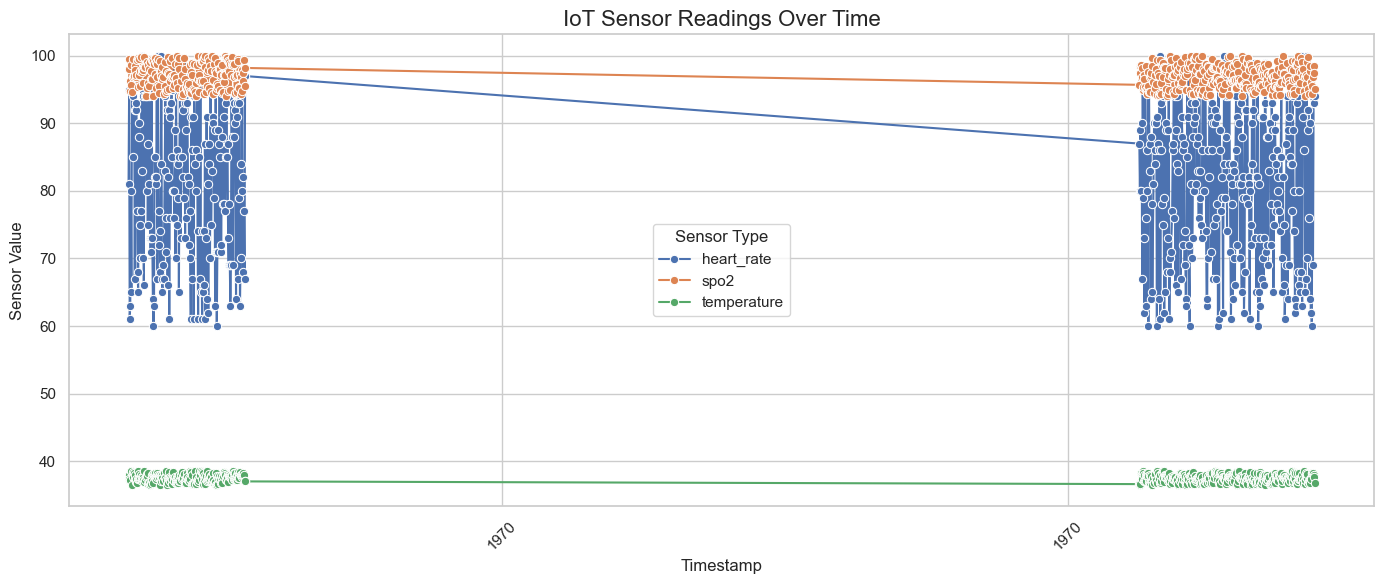

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load the stored IoT data
df = pd.read_csv("iot_data_records.csv")

# convert timestamp column to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# melt the DataFrame for Seaborn multi-line plot
df_melted = df.melt(
    id_vars="timestamp",
    value_vars=["heart_rate", "spo2", "temperature"],
    var_name="data_type",
    value_name="numeric_value"
)

# convert numeric values (remove units if any and parse as float)
df_melted["numeric_value"] = df_melted["numeric_value"].str.extract(r"(\d+\.?\d*)").astype(float)

# visualization style
sns.set(style="whitegrid")

# line plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_melted, x="timestamp", y="numeric_value", hue="data_type", marker="o")

# customize plot
plt.xticks(rotation=45)
plt.title("IoT Sensor Readings Over Time", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Sensor Value", fontsize=12)
plt.legend(title="Sensor Type")
plt.tight_layout()

plt.show()
